In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model

In [29]:
# Functions

def line(x, m, b):
    return x * m + b

def tlm(s, r_s, N, w, L, r_c):
    return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)

def tlm2(s, r_s, N, w, L, l_t):
    return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)

def w_contact(s, N, w, L):
    return (2 * N * (w + L + s)) - L - s

# Variables

idea2 = {'P01': 2e-4,
         'P02': 5e-4,
         'P03': 10e-4,
         'P04' : 20e-4
         }

col = ['Potential (V)', 'Current (A)', 'Time (s)']
col2 = ['Structure', 'Spacing (cm)', 'Resistance ($\Omega$)']

# Models

line_mod = Model(line)
line_params = line_mod.make_params()
line_params['m'].set(value = 1)
line_params['b'].set(value = 1)

# Not considering L_t transfer lenght
tlm_mod = Model(tlm)
tlm_params = tlm_mod.make_params()
tlm_params['r_s'].set(value = 1e6)
tlm_params['N'].set(value = 60, vary = False)
tlm_params['w'].set(value = 5e-4, vary = False)
tlm_params['L'].set(value = 3200e-4, vary = False)
tlm_params['r_c'].set(value = 1)

# Considering L_t to get \rho_c Contact Resistivity
tlm_mod2 = Model(tlm2)
tlm2_params = tlm_mod2.make_params()
tlm2_params['r_s'].set(value = 1e6)
tlm2_params['N'].set(value = 60, vary = False)
tlm2_params['w'].set(value = 5e-4, vary = False)
tlm2_params['L'].set(value = 3200e-4, vary = False)
tlm2_params['l_t'].set(value = 1, min = 0)

In [30]:
# Function to process data

def C_R(path, sample):
    
    files = [os.path.join(path, i) for i in os.listdir(path)]
    iv_val = pd.DataFrame(columns = col2)

    n = 0
    for i in files:
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col)
        line_fit = line_mod.fit(df[col[1]], line_params, x = df[col[0]])
        resistance = 1 / line_fit.values['m']
        
        for j in idea2.keys():
            if j in i:
                iv_val.loc[n] = (j, idea2[j], resistance)
        n += 1

    iv_val['Sample'] = sample
    
    width_ = (w_contact(iv_val[col2[1]], 60, 5e-4, 3200e-4))
    width_avg = width_.mean()

    # # Model without L_t
    # tlm_fit = tlm_mod.fit(iv_val[col2[2]], tlm_params, s = iv_val[col2[1]])
    # print(tlm_fit.fit_report())

    # # Plot
    # sns.scatterplot(data = iv_val, x = col2[1], y = col2[2])
    # plt.plot(iv_val[col2[1]], tlm_fit.best_fit)

    tlm_fit2 = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]])
    print(tlm_fit2.fit_report())
    rc = tlm_mod2.eval(tlm_fit2.params, s = 0) / 2
    lt = tlm_fit2.values['l_t']
    p_c = rc * lt * width_avg #Contact resistiviy ohm * cm^2
    
    # Average
    
    val_avg = pd.DataFrame()
    u_s = iv_val.Structure.unique()
    df_dict = {i : pd.DataFrame() for i in u_s}
    for key in df_dict.keys():
        df_dict[key] = iv_val[:][iv_val.Structure == key]
    for key, df in df_dict.items():
        mean_ = df.mean(numeric_only = True).reset_index().transpose()
        mean_.columns = mean_.iloc[0]
        mean_ = mean_[1:].reset_index(drop=True)
        val_avg = pd.concat([val_avg, mean_], ignore_index = True)  
    
    ##############
    
    tlm_fit_avg = tlm_mod2.fit(val_avg[col2[2]], tlm2_params, s = val_avg[col2[1]])
    print(tlm_fit_avg.fit_report())
    rc2 = tlm_mod2.eval(tlm_fit_avg.params, s = 0) / 2
    lt2 = tlm_fit_avg.values['l_t']
    p_c2 = rc2 * lt2 * width_avg #Contact resistiviy ohm * cm^2
    
    # Plot
    fig, ax = plt.subplots( figsize = (8, 5), dpi = 100)
    sns.scatterplot(data = iv_val, x = col2[1], y = col2[2], label = 'Data')
    ax.plot(iv_val[col2[1]], tlm_fit2.best_fit, 'tab:orange', label = 'Fit')
    
    fig, ax = plt.subplots( figsize = (8, 5), dpi = 100)
    sns.scatterplot(data = val_avg, x = col2[1], y = col2[2], label = 'Data avg')
    ax.plot(val_avg[col2[1]], tlm_fit_avg.best_fit, 'tab:orange', label = 'Fit')
    sns.lineplot(data = iv_val, x = col2[1], y = col2[2], marker='', errorbar='sd',err_style='bars', linestyle='')
    
    # # plt.legend()
    # # print(width_)
    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    print('Contact Resistivity2 = ' + str(p_c2) + ' Ohm cm2')
    print('LMO 1 / sheet resistance = ' + str(1/tlm_fit2.values['r_s']))
    print('LMO 1 / sheet resistance2 = ' + str(1/tlm_fit_avg.values['r_s']))
    
    result = [iv_val, val_avg]
    return result

[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 237
    # data points      = 15
    # variables        = 2
    chi-square         = 4.2272e+12
    reduced chi-square = 3.2517e+11
    Akaike info crit   = 399.467544
    Bayesian info crit = 400.883644
    R-squared          = 0.92836616
[[Variables]]
    r_s:  1.1387e+11 +/- 8.7456e+09 (7.68%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  7.4895e-05 +/- 4.5682e-05 (60.99%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.841
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 361
    # data points      = 4
    # variables        = 2
    chi-square         = 4.1894e+10
    reduced chi-square = 2.0947e+10
    Akaike info crit   = 96.2884855
    Bayesian info crit = 95.0610742
    R-squared          = 0.99742885
[[Variables]]
    r_s:  1.1337e+11 +/

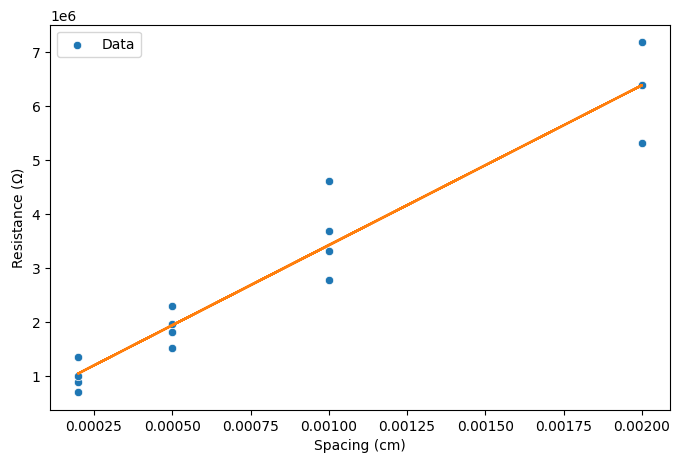

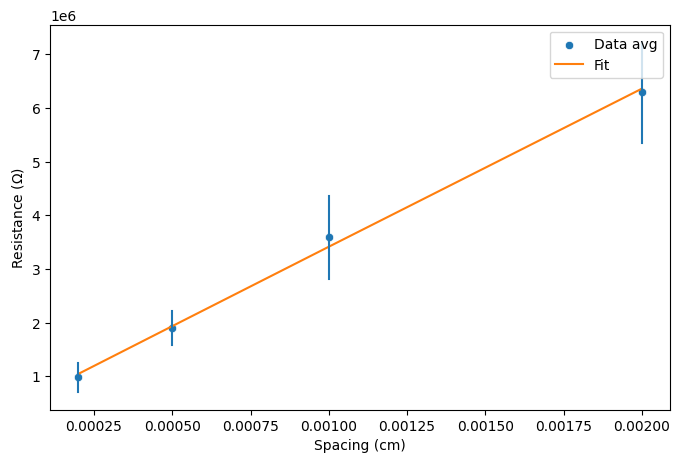

In [31]:
# 0G_37 low_left
# Potentiostat
sample = 'low_left'
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_37\low_left\AUT'
low_l = C_R(path, sample)

In [32]:
# 0G_37 low_leftLCR



[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 224
    # data points      = 8
    # variables        = 2
    chi-square         = 3.5790e+11
    reduced chi-square = 5.9650e+10
    Akaike info crit   = 200.192676
    Bayesian info crit = 200.351559
    R-squared          = 0.98981741
[[Variables]]
    r_s:  1.1724e+11 +/- 4.8402e+09 (4.13%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  1.3409e-05 +/- 2.4123e-05 (179.90%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.812
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 224
    # data points      = 4
    # variables        = 2
    chi-square         = 8.3647e+09
    reduced chi-square = 4.1824e+09
    Akaike info crit   = 89.8439790
    Bayesian info crit = 88.6165677
    R-squared          = 0.99951937
[[Variables]]
    r_s:  1.1724e+11 +/

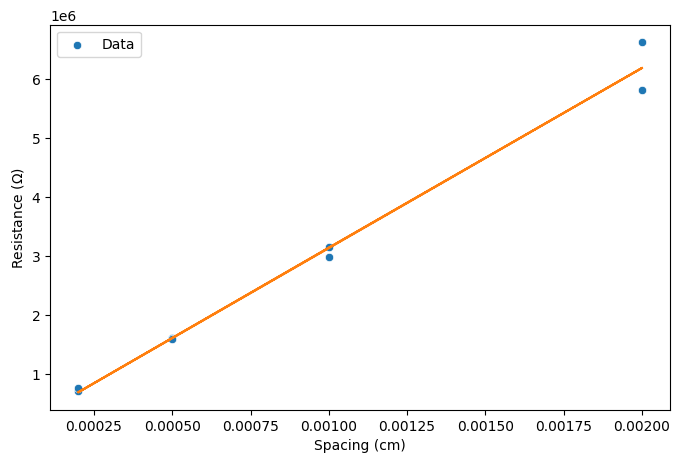

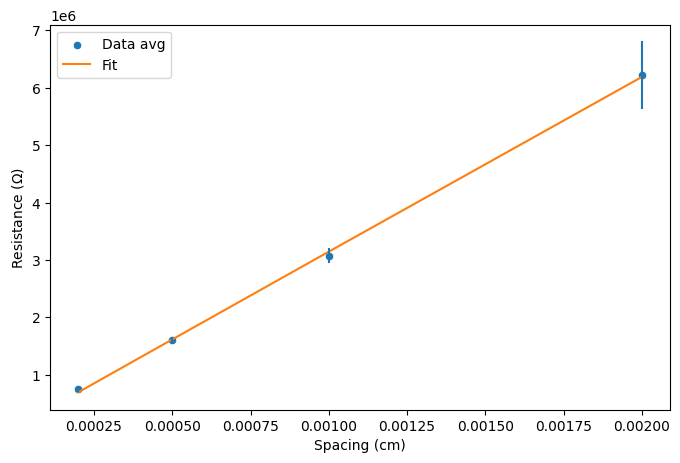

In [33]:
# 0G_37 up_left
# Potentiostat
sample = 'up_left'
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_37\up_left'
up_l = C_R(path, sample)

[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 360
    # data points      = 12
    # variables        = 2
    chi-square         = 1.4222e+11
    reduced chi-square = 1.4222e+10
    Akaike info crit   = 282.348471
    Bayesian info crit = 283.318285
    R-squared          = 0.99807988
[[Variables]]
    r_s:  1.3954e+11 +/- 1.9297e+09 (1.38%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  2.3467e-05 +/- 8.1938e-06 (34.92%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.818
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 360
    # data points      = 4
    # variables        = 2
    chi-square         = 7.9450e+09
    reduced chi-square = 3.9725e+09
    Akaike info crit   = 89.6380547
    Bayesian info crit = 88.4106434
    R-squared          = 0.99967768
[[Variables]]
    r_s:  1.3954e+11 +/

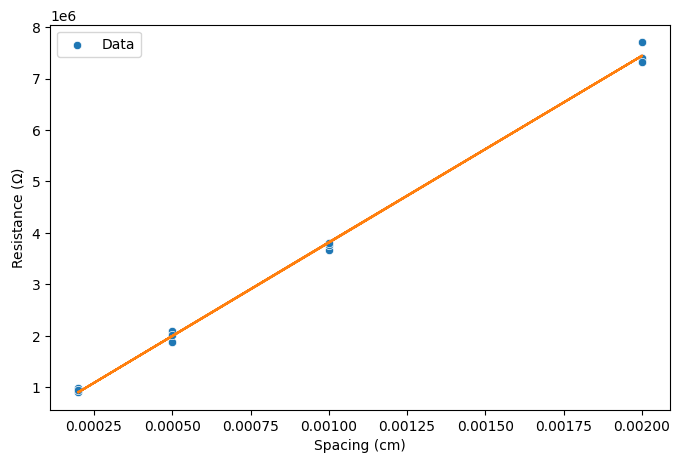

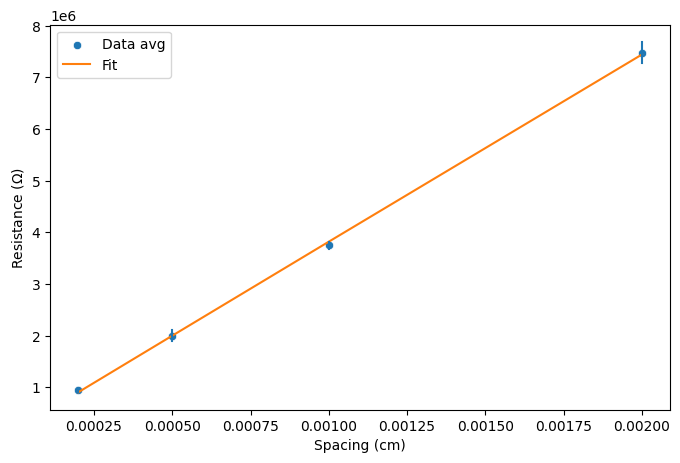

In [34]:
# 0G_38 up_L
sample = 'up_L'
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_38\up_L'
up_l = C_R(path, sample)


[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 358
    # data points      = 8
    # variables        = 2
    chi-square         = 3.2881e+11
    reduced chi-square = 5.4801e+10
    Akaike info crit   = 199.514407
    Bayesian info crit = 199.673290
    R-squared          = 0.99074726
[[Variables]]
    r_s:  1.1797e+11 +/- 4.6393e+09 (3.93%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  5.9215e-05 +/- 2.4465e-05 (41.32%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.836
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 358
    # data points      = 4
    # variables        = 2
    chi-square         = 8.0712e+10
    reduced chi-square = 4.0356e+10
    Akaike info crit   = 98.9114512
    Bayesian info crit = 97.6840400
    R-squared          = 0.99543598
[[Variables]]
    r_s:  1.1797e+11 +/-

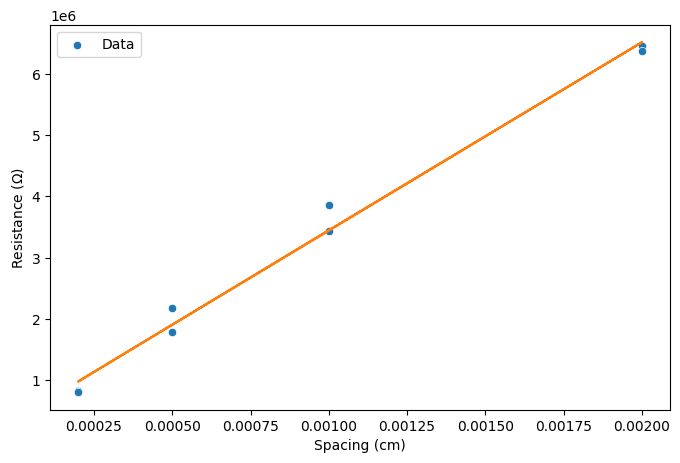

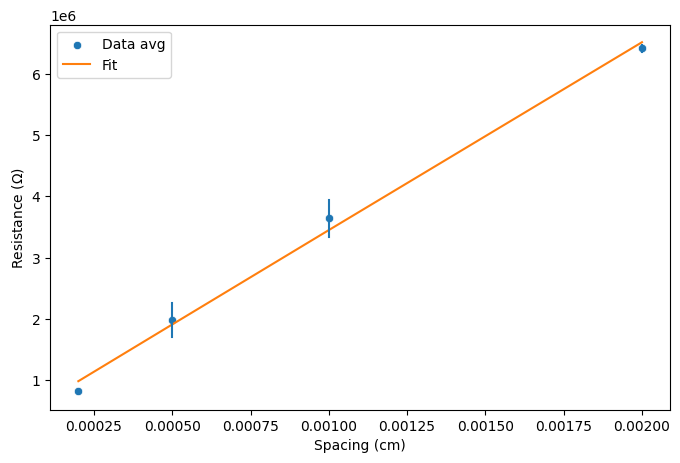

In [35]:
# 0G_38 up_R
sample = 'up_R'
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_38\up_R'
up_r = C_R(path, sample)

[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 363
    # data points      = 4
    # variables        = 2
    chi-square         = 2.8842e+09
    reduced chi-square = 1.4421e+09
    Akaike info crit   = 85.5849047
    Bayesian info crit = 84.3574935
    R-squared          = 0.99985745
[[Variables]]
    r_s:  1.2646e+11 +/- 1.0643e+09 (0.84%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  4.6569e-05 +/- 5.1478e-06 (11.05%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.830
Contact Resistivity2 = 274.99701597956715 Ohm cm2


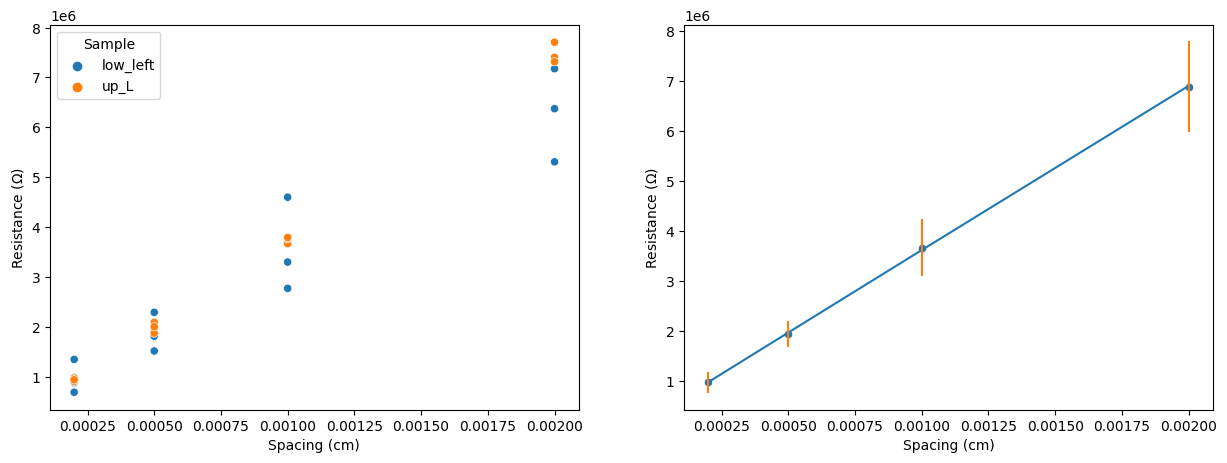

In [36]:
all = pd.concat([low_l[0], up_l[0]], ignore_index = True)


all_avg = pd.DataFrame()
u_s = all.Structure.unique()
df_dict = {i : pd.DataFrame() for i in u_s}
for key in df_dict.keys():
    df_dict[key] = all[:][all.Structure == key]
for key, df in df_dict.items():
    mean_ = df.mean(numeric_only = True).reset_index().transpose()
    mean_.columns = mean_.iloc[0]
    mean_ = mean_[1:].reset_index(drop=True)
    all_avg = pd.concat([all_avg, mean_], ignore_index = True)


width_ = (w_contact(all['Spacing (cm)'], 60, 5e-4, 3200e-4))
width_avg = width_.mean()

tlm_fit_avg = tlm_mod2.fit(all_avg['Resistance ($\Omega$)'], tlm2_params, s = all_avg['Spacing (cm)'])
print(tlm_fit_avg.fit_report())
rc2 = tlm_mod2.eval(tlm_fit_avg.params, s = 0) / 2
lt2 = tlm_fit_avg.values['l_t']
p_c2 = rc2 * lt2 * width_avg #Contact resistiviy ohm * cm^2

fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 100)
sns.scatterplot(data = all, x = 'Spacing (cm)', y = 'Resistance ($\Omega$)', hue = 'Sample', ax = ax[0])
sns.scatterplot(data = all_avg, x = 'Spacing (cm)', y = 'Resistance ($\Omega$)', ax = ax[1])
sns.lineplot(x = all_avg['Spacing (cm)'], y = tlm_fit_avg.best_fit)
sns.lineplot(data = all, x = 'Spacing (cm)', y = 'Resistance ($\Omega$)', marker='', errorbar='sd',err_style='bars', linestyle='', ax = ax[1])

print('Contact Resistivity2 = ' + str(p_c2) + ' Ohm cm2')


In [37]:
fix_path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_38_tofix\up_L'
exp_path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_38\up_L'
files = [os.path.join(fix_path, i) for i in os.listdir(fix_path)]
for i in files:
    df = pd.read_csv(i, sep = ';', usecols=[0,2,1])
    # plt.plot(df['Potential applied (V)'], df['WE(1).Current (A)'])
    df = df[['Potential applied (V)', 'WE(1).Current (A)', 'Time (s)']]
    df.to_csv(os.path.join(exp_path, i[-10:]), sep=';', index=False)
# df